In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import string

%matplotlib inline

In [2]:
train_df = pd.read_parquet('./data/train.parquet')
test_df = pd.read_parquet('./data/test.parquet')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
train_df.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [4]:
test_df.head()

,Body,Tags,Title
Id,,,
46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...
38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code'
44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...
34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...
51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?


In [5]:
submission.head()

,Id,Predicted
0,46785369,0
1,38908667,0
2,44703012,0
3,34910435,0
4,51632121,0


In [6]:
labels = train_df.target
data = train_df.drop('target', axis=1)

In [7]:
labels.shape

(48000,)

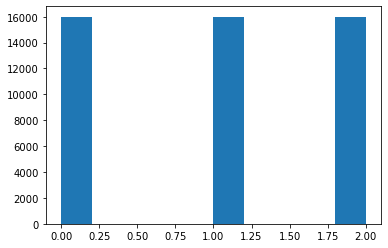

In [8]:
plt.hist(labels)
plt.show()

In [9]:
full_data = pd.concat([data, test_df])

In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

text_columns = ['Body', 'Title']
for column in text_columns:
    full_data[column] = full_data[column].apply(lambda x: remove_URL(x))

In [11]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

for column in text_columns:
    full_data[column] = full_data[column].apply(lambda x: remove_html(x))

In [12]:
def remove_punct(text):
    table=str.maketrans('','', string.punctuation)
    return text.translate(table)

for column in text_columns:
    full_data[column] = full_data[column].apply(lambda x: remove_punct(x))

In [13]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

# for column in text_columns:
#     full_data[column] = full_data[column].apply(lambda x: correct_spellings(x))

In [14]:
def split_tags(text):
    return text[1: -1].split('><')

tags = full_data['Tags'].apply(lambda x: split_tags(x))

In [15]:
# unique_tags = np.unique(tags.to_numpy().flatten())
unique_tags = []
for _, value in tags.items():
    unique_tags += value
unique_tags, tags_counts = np.unique(unique_tags, return_counts=True)

In [16]:
len(unique_tags)

10703

In [17]:
sorted_idxs = np.argsort(tags_counts)[::-1]
tags_counts = tags_counts[sorted_idxs]
unique_tags = unique_tags[sorted_idxs]

In [18]:
print(unique_tags[:10])
print(tags_counts[:10])

['javascript' 'python' 'java' 'android' 'php' 'c#' 'html' 'c++' 'css' 'c']
[7106 6800 6242 4838 4161 4154 3376 3003 2104 1845]


In [21]:
unique_tags[:100]

array(['javascript', 'python', 'java', 'android', 'php', 'c#', 'html',
       'c++', 'css', 'c', 'arrays', 'jquery', 'ios', 'sql', 'mysql',
       'swift', 'angular', 'python-3.x', 'reactjs', 'r', 'regex',
       'node.js', 'sql-server', 'json', 'string', 'typescript', 'linux',
       'excel', 'docker', 'pandas', 'list', '.net', 'android-studio',
       'react-native', 'ruby', 'vba', 'laravel', 'asp.net', 'xcode',
       'flutter', 'go', 'firebase', 'git', 'database',
       'amazon-web-services', 'kotlin', 'bash', 'visual-studio',
       'angularjs', 'function', 'python-2.7', 'algorithm', 'django',
       'vue.js', 'windows', 'wordpress', 'oracle', 'loops', 'spring',
       'asp.net-core', 'dictionary', 'ruby-on-rails', 'objective-c',
       'tensorflow', 'ajax', 'date', 'visual-studio-code', 'if-statement',
       'asp.net-mvc', 'sorting', 'spring-boot', 'xml', 'for-loop', 'dart',
       'pointers', 'selenium', 'numpy', 'dataframe', 'ecmascript-6',
       'webpack', 'macos', 'vb.net'

In [20]:
top_tags = unique_tags[:100]
tags_features = np.zeros((full_data.shape[0], 100), dtype=np.int8)

for i, (_, tags_list) in enumerate(tags.items()):
    for j, tag in enumerate(top_tags):
        if tag in tags_list:
            tags_features[i: j] = 1

In [21]:
top_tags_names = [f'tag_{tag}' for tag in top_tags]
for j in range(100):
    full_data[top_tags_names[j]] = tags_features[:, j]

C:\Users\nikti\AppData\Local\Temp/ipykernel_4856/4057936096.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  full_data[top_tags_names[j]] = tags_features[:, j]


In [22]:
full_data

,Body,Tags,Title,tag_javascript,tag_python,tag_java,tag_android,tag_php,tag_c#,tag_html,...,tag_postgresql,tag_perl,tag_sqlite,tag_shell,tag_machine-learning,tag_csv,tag_datetime,tag_multithreading,tag_object,tag_android-layout
Id,,,,,,,,,,,,,,,,,,,,,
34862324,Algorithmm\r\n\r\ninput Graph G\r\n\r\noutput...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
47303682,While converting the data frame to HTML Date i...,<html><r><dataframe>,R Studio Date is getting converted to number w...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
46431243,This should be an easy one but somehow I could...,<python><pandas><dataframe><pandas-groupby>,Pandas dataframe groupby how to get sum of m...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
45306324,Let say I have a component in Angular 2 that n...,<angular><typescript><rxjs>,Casting results from ObservableforkJoin to the...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
49479547,Im setting a var using \nset TESTVAR5 \nand th...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37771316,I am having trouble to invoke click event from...,<javascript><reactjs>,React Triggering click event on table row,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59044957,I want to keep the ratio of DIV\nFor example\n...,<jquery><css><twitter-bootstrap>,Keep ratio of DIV or img,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57190511,I have rewritten my sign in view controller as...,<ios><uikit><swiftui>,Dismiss a SwiftUI View that is contained in a ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def tags_to_str(text):
    return ' '.join(text[1: -1].split('><'))

full_data['Tags'] = full_data['Tags'].apply(lambda x: tags_to_str(x))

In [24]:
def remove_slash_symbols(text):
    unslashed = re.compile(r'[\n\t\r]')
    return unslashed.sub(r' ',text)

for column in text_columns:
    full_data[column] = full_data[column].apply(lambda x: remove_slash_symbols(x))

In [33]:
pd.isna(full_data[['Body', 'Tags', 'Title']]).any()

Body     False
Tags     False
Title    False
dtype: bool

In [37]:
full_data[full_data.index.isin([42407720, 36240495])]

,Body,Tags,Title,tag_javascript,tag_python,tag_java,tag_android,tag_php,tag_c#,tag_html,...,tag_postgresql,tag_perl,tag_sqlite,tag_shell,tag_machine-learning,tag_csv,tag_datetime,tag_multithreading,tag_object,tag_android-layout
Id,,,,,,,,,,,,,,,,,,,,,
42407720,npm WARN optional SKIPPING OPTIONAL DEPENDENCY...,node.js mongodb,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36240495,I trying to make a request GET to import req...,python,,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
full_data

,Body,Tags,Title,tag_javascript,tag_python,tag_java,tag_android,tag_php,tag_c#,tag_html,...,tag_postgresql,tag_perl,tag_sqlite,tag_shell,tag_machine-learning,tag_csv,tag_datetime,tag_multithreading,tag_object,tag_android-layout
Id,,,,,,,,,,,,,,,,,,,,,
34862324,Algorithmm input Graph G output Set of ...,java algorithm graph-algorithm,I am implementing a Minimum Spanning Forrest a...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
47303682,While converting the data frame to HTML Date i...,html r dataframe,R Studio Date is getting converted to number w...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
46431243,This should be an easy one but somehow I could...,python pandas dataframe pandas-groupby,Pandas dataframe groupby how to get sum of m...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
45306324,Let say I have a component in Angular 2 that n...,angular typescript rxjs,Casting results from ObservableforkJoin to the...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
49479547,Im setting a var using set TESTVAR5 and then...,c windows batch-file,Environment variable set in batch file cannot ...,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37771316,I am having trouble to invoke click event from...,javascript reactjs,React Triggering click event on table row,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59044957,I want to keep the ratio of DIV For example I ...,jquery css twitter-bootstrap,Keep ratio of DIV or img,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57190511,I have rewritten my sign in view controller as...,ios uikit swiftui,Dismiss a SwiftUI View that is contained in a ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
full_data.to_csv('./data/preprocessed/full_data.1.csv', index_label='Id')

In [27]:
labels

Id
34862324    2
47303682    2
46431243    0
45306324    0
49479547    1
           ..
35488105    1
37045803    1
43601747    0
40505904    0
40415937    2
Name: target, Length: 48000, dtype: int64

In [28]:
labels.to_csv('./data/preprocessed/labels.csv', index_label='Id')